### can run this one by one interactively or, as a batch, run `../scripts/general_postproc.py`

In [20]:
import sys
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import zipfile
sys.path.insert(0,'../scripts/')
from postprocessing import setup_postproc, check_pdc, plot_phi, get_obs_and_noise, get_pars, plot_group, plot_pars_group

In [2]:
curr_model = '01473000'
# curr_model = '05431486'
# curr_model = '09112500'
curr_run_root = 'prior_mc_reweight'
eval_pdc = True
unzip_dirs = True
phi_cutoffs = {cm:{crr:9e99 for crr in ['ies','prior_mc_reweight']}
                for cm in ['01473000','05431486', '09112500']}
pstdir, results_file, tmp_res_path, fig_dir, obs, pst = setup_postproc(curr_model, curr_run_root, unzip_dirs)

error parsing metadata from 'obsnme', continuing


### check out PDC

In [3]:
pst.nnz_obs_groups

['g_min_actet_mean_mon',
 'g_min_actet_mon',
 'g_min_recharge_ann',
 'g_min_runoff_mon',
 'g_min_soil_moist_ann',
 'g_min_soil_moist_mon',
 'l_max_actet_mean_mon',
 'l_max_actet_mon',
 'l_max_recharge_ann',
 'l_max_runoff_mon',
 'l_max_soil_moist_ann',
 'l_max_soil_moist_mon',
 'streamflow_daily_large_asc',
 'streamflow_daily_small_asc',
 'streamflow_daily_small_dsc',
 'streamflow_daily_pulse_asc',
 'streamflow_daily_pulse_dsc',
 'streamflow_daily_low',
 'streamflow_daily_exlow',
 'streamflow_mean_mon',
 'streamflow_mon']

In [4]:
if eval_pdc:
    pdc = check_pdc(tmp_res_path, curr_run_root, pst, obs)
    print(pdc)

2.31% of weighted obs are in PDC
                            obs_counts  pdc_counts group_percent_pdc
obgnme                                                              
g_min_actet_mean_mon               204        11.0             5.39%
g_min_actet_mon                   2244       180.0             8.02%
g_min_recharge_ann                 170         9.0             5.29%
g_min_runoff_mon                  5916         NaN              nan%
g_min_soil_moist_ann               493         1.0             0.20%
g_min_soil_moist_mon              5916        57.0             0.96%
l_max_actet_mean_mon               204         NaN              nan%
l_max_actet_mon                   2244         7.0             0.31%
l_max_recharge_ann                 170         NaN              nan%
l_max_runoff_mon                  5916         NaN              nan%
l_max_soil_moist_ann               493         NaN              nan%
l_max_soil_moist_mon              5916         7.0             0.12%
s

### look at PHI history

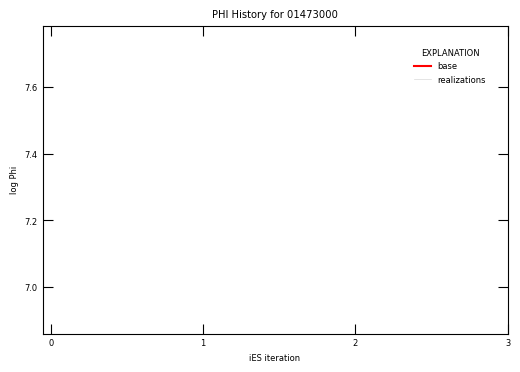

In [5]:
phi = plot_phi(tmp_res_path, curr_run_root, curr_model, fig_dir)

### Truncate PHI at a threshold

In [6]:
phi

,total_runs,mean,standard_deviation,min,max,0,1,2,3,4,...,490,491,492,493,494,495,496,497,498,base
iteration,,,,,,,,,,,,,,,,,,,,,
0,500,29634300.0,7611520.0,7982550.0,55279300.0,28759600.0,24107100.0,31570300.0,28039200.0,33676000.0,...,41892400.0,26723200.0,25040300.0,27343000.0,23521000.0,35509500.0,26132300.0,37271500.0,26804000.0,7982550.0


In [7]:
best_iter = 0
if 'prior' in curr_run_root:
    best_iter = 0
best_iter

0

## now rejection sampling for outlier PHI values

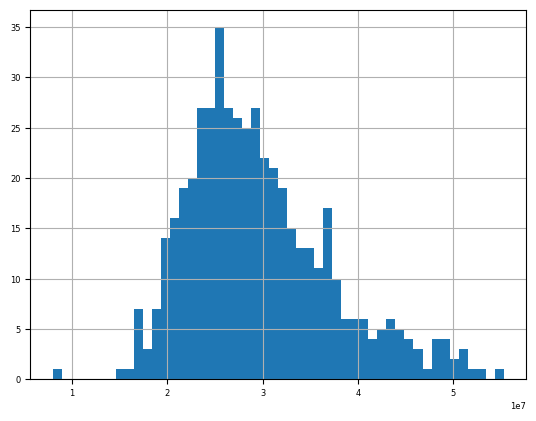

In [8]:
orgphi = phi.loc[best_iter].iloc[5:].copy()
ax = orgphi.hist(bins=50)
lims = ax.get_xlim()

In [9]:
# catalog of cutoffs heuristically determined
phi_cutoffs['01473000']['prior_mc_reweight'] = 4.0e7
phi_cutoffs['01473000']['ies'] = 1.08e9
phi_cutoffs['05431486']['prior_mc_reweight'] = .6e12
phi_cutoffs['05431486']['ies'] = 7.5e8
phi_cutoffs['09112500']['prior_mc_reweight'] = 1.2e9
phi_cutoffs['09112500']['ies'] = 8.675e8

In [10]:
phi_too_high = phi_cutoffs[curr_model][curr_run_root]
phi_too_high

40000000.0

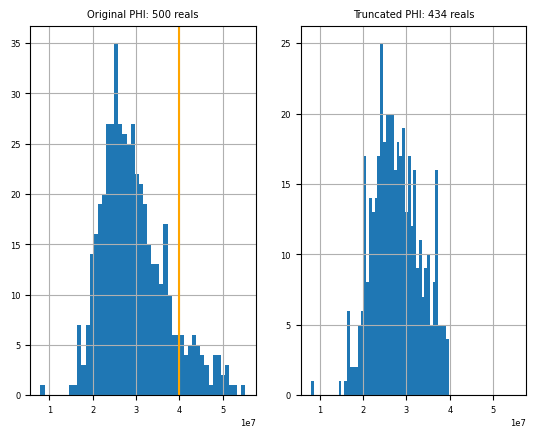

In [11]:
phi = orgphi.loc[orgphi<=phi_too_high]
fig,ax = plt.subplots(1,2)
### --> need to indicate which reals we will carry forward <-- ###
orgphi.hist(bins=50, ax=ax[0])
reals = phi.index 
phi.hist(bins=50, ax=ax[1])
ax[0].axvline(phi_too_high, color='orange')
ax[1].set_xlim(lims)
ax[0].set_title(f'Original PHI: {len(orgphi)} reals')
ax[1].set_title(f'Truncated PHI: {len(phi)} reals')
plt.savefig(fig_dir/ 'phi_histogram.pdf')


### now read in and trim hotstart files

In [12]:
parens = pd.read_csv(tmp_res_path / f'{curr_run_root}.{best_iter}.par.csv',
                         index_col=0, low_memory=False).loc[reals]

In [13]:
parens.index = [str(i) for i in range(len(parens)-1)] + ['base']

In [14]:
parens.to_csv(pstdir / 'hotstart.starting_pars.csv.zip')

In [15]:
obens = pd.read_csv(tmp_res_path / f'{curr_run_root}.{best_iter}.obs.csv', 
                    low_memory=False, index_col=0).loc[reals]
obens.index = parens.index
obens_noise = pd.read_csv(tmp_res_path / f'{curr_run_root}.obs+noise.csv', 
                          low_memory=False, index_col=0).loc[reals]
obens_noise.index = parens.index

In [16]:
obens.to_csv(pstdir / 'hotstart.starting_obs.csv.zip')
obens_noise.to_csv(pstdir / 'hotstart.starting_obs+noise.csv.zip')


In [17]:
pst.control_data.noptmax=2
pst.pestpp_options["ies_num_reals"] = len(reals)
pst.pestpp_options["ies_observation_ensemble"] = 'hotstart.starting_obs+noise.csv'
pst.pestpp_options["ies_restart_observation_ensemble"] = 'hotstart.starting_obs.csv'
pst.pestpp_options["ies_parameter_ensemble"] = 'hotstart.starting_pars.csv'

In [18]:
pst.pestpp_options

{'ies_num_reals': 434,
 'ies_bad_phi_sigma': 2.5,
 'overdue_giveup_fac': 4,
 'ies_no_noise': 'false',
 'ies_drop_conflicts': 'false',
 'ies_pdc_sigma_distance': 3.0,
 'ies_autoadaloc': 'false',
 'ies_num_threads': 4,
 'ies_lambda_mults': '0.1,1.0,10.0,100.0',
 'lambda_scale_fac': '0.75,0.9,1.0,1.1',
 'ies_subset_size': 10,
 'ies_localizer': 'loc.mat',
 'ies_observation_ensemble': 'hotstart.starting_obs+noise.csv',
 'ies_restart_observation_ensemble': 'hotstart.starting_obs.csv',
 'ies_parameter_ensemble': 'hotstart.starting_pars.csv'}

In [19]:
pst.write(str(pstdir / 'ies_hot.pst'), version=2)

noptmax:2, npar_adj:2339, nnz_obs:46534


In [21]:
with zipfile.ZipFile(pstdir / f'{curr_model}.hotstart.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    [zipf.write(i, i.name) for i in pstdir.glob('hotstart.starting*.zip')]